In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines
import matplotlib.ticker as mtick
import matplotlib.gridspec as grid_spec
from matplotlib.patches import Rectangle

import pandas as pd
import statsmodels.api as sm

# import pyarrow.parquet as pq
# import pyarrow as pa


import os

import itertools
import collections

#---NLP packages--------------------
import nltk
from nltk import bigrams
from nltk.corpus import stopwords
from nltk.util import ngrams

#----process string-------
import string
import re

#---network visualization-----------
import re
import networkx as nx


import warnings
warnings.filterwarnings("ignore")

In [17]:
def clean_text(sentence):
    sentence = re.sub("[%s]" % re.escape(string.punctuation), "", sentence.lower())
    sentence = re.sub("([^\x00-\x7F])+", " ", sentence)    
    sentence = sentence.replace('\n', ' ').replace('.', ' ').replace(',', ' ').replace('?', ' ')\
    .replace('\r', ' ').replace('!', ' ').replace('"\r', ' ').replace('"', ' ')\
    .replace("'", ' ').replace("''", ' ').replace('(', ' ').replace(')', ' ').replace(']', ' ')\
    .replace('-', ' ').replace('/', ' ')
    
    while ('  ' in sentence):
        sentence = sentence.replace('  ', ' ')
    return sentence

In [18]:
eng_stopwords = set(stopwords.words('english')) | {''}

In [19]:
def get_words(sentence, stopwords):
    words = set(sentence.split(' '))
    words = list(words-set(stopwords))
    if '' in words:
        words.remove('')   
    return list(words)

In [20]:
df = pd.read_csv("test_prediction_8020_final.csv")

In [21]:
txts = df['comments'].values.tolist()
words_in_text = []
for txt in txts:
    txt = clean_text(txt)
    words_in_text.append(get_words(txt, eng_stopwords))

In [22]:
word_pairs = []
for words in words_in_text:
    words_ = list(set(words))
    for i in range(len(words_)-1):
        for j in range(i+1, len(words_)):
            word_i = words_[i]
            word_j = words_[j]
            if word_i < word_j:
                word_pairs.append([word_i, word_j])
            else:
                word_pairs.append([word_i, word_j])

In [23]:
df_word_pairs = pd.DataFrame(data = word_pairs, columns=['word1', 'word2'])
word_pairs_count = df_word_pairs.groupby(['word1', 'word2']).size()
word_pairs_count = word_pairs_count.sort_values().tail(200).reset_index()

In [24]:
word_pairs_count.tail(10)

,word1,word2,0
190,location,place,6445
191,nice,place,6508
192,clean,great,6786
193,clean,stay,7268
194,clean,room,8086
195,clean,place,8337
196,area,tourist,9121
197,great,place,9571
198,stay,great,9678
199,stay,place,11344


# BIGRAM

In [25]:
# Create list of lists containing bigrams 
terms_bigram = [list(bigrams(words)) for words in words_in_text]

# View bigrams for the first assay
print('View bigrams for the first assay')
print(terms_bigram[0][:5])

# Flatten list of bigrams in clean text
bigram_list = list(itertools.chain(*terms_bigram))

# Create counter of words in clean bigrams
bigram_counts = collections.Counter(bigram_list)

bigram_counts.most_common(5)

View bigrams for the first assay
[('bars', 'quirky'), ('quirky', 'caf'), ('caf', 'bar'), ('bar', 'great'), ('great', 'spacious')]


[(('good', 'place'), 2776),
 (('place', 'hcm'), 2633),
 (('clean', 'stay'), 2388),
 (('clean', 'nice'), 2158),
 (('also', 'stay'), 2100)]

In [26]:
# Create list of lists containing bigrams 
terms_3gram = [list(ngrams(words, 3)) for words in words_in_text]

# View bigrams for the first assay
print('View N-grams (N=3) for the first assay')
print(terms_3gram[0][:5])


gram3_list = list(itertools.chain(*terms_3gram))

# Create counter of words in clean bigrams
gram3_counts = collections.Counter(gram3_list)

gram3_counts.most_common(5)

View N-grams (N=3) for the first assay
[('bars', 'quirky', 'caf'), ('quirky', 'caf', 'bar'), ('caf', 'bar', 'great'), ('bar', 'great', 'spacious'), ('great', 'spacious', 'utterly')]


[(('clean', 'well', 'stay'), 561),
 (('clean', 'also', 'stay'), 522),
 (('clean', 'station', 'stay'), 402),
 (('stay', 'come', 'back'), 356),
 (('tourist', 'place', 'hcm'), 316)]

In [27]:
# Create network plot 
G = nx.Graph()


for _, row in word_pairs_count.iterrows():
    G.add_edge(row['word1'], row['word2'], weight=row[0])

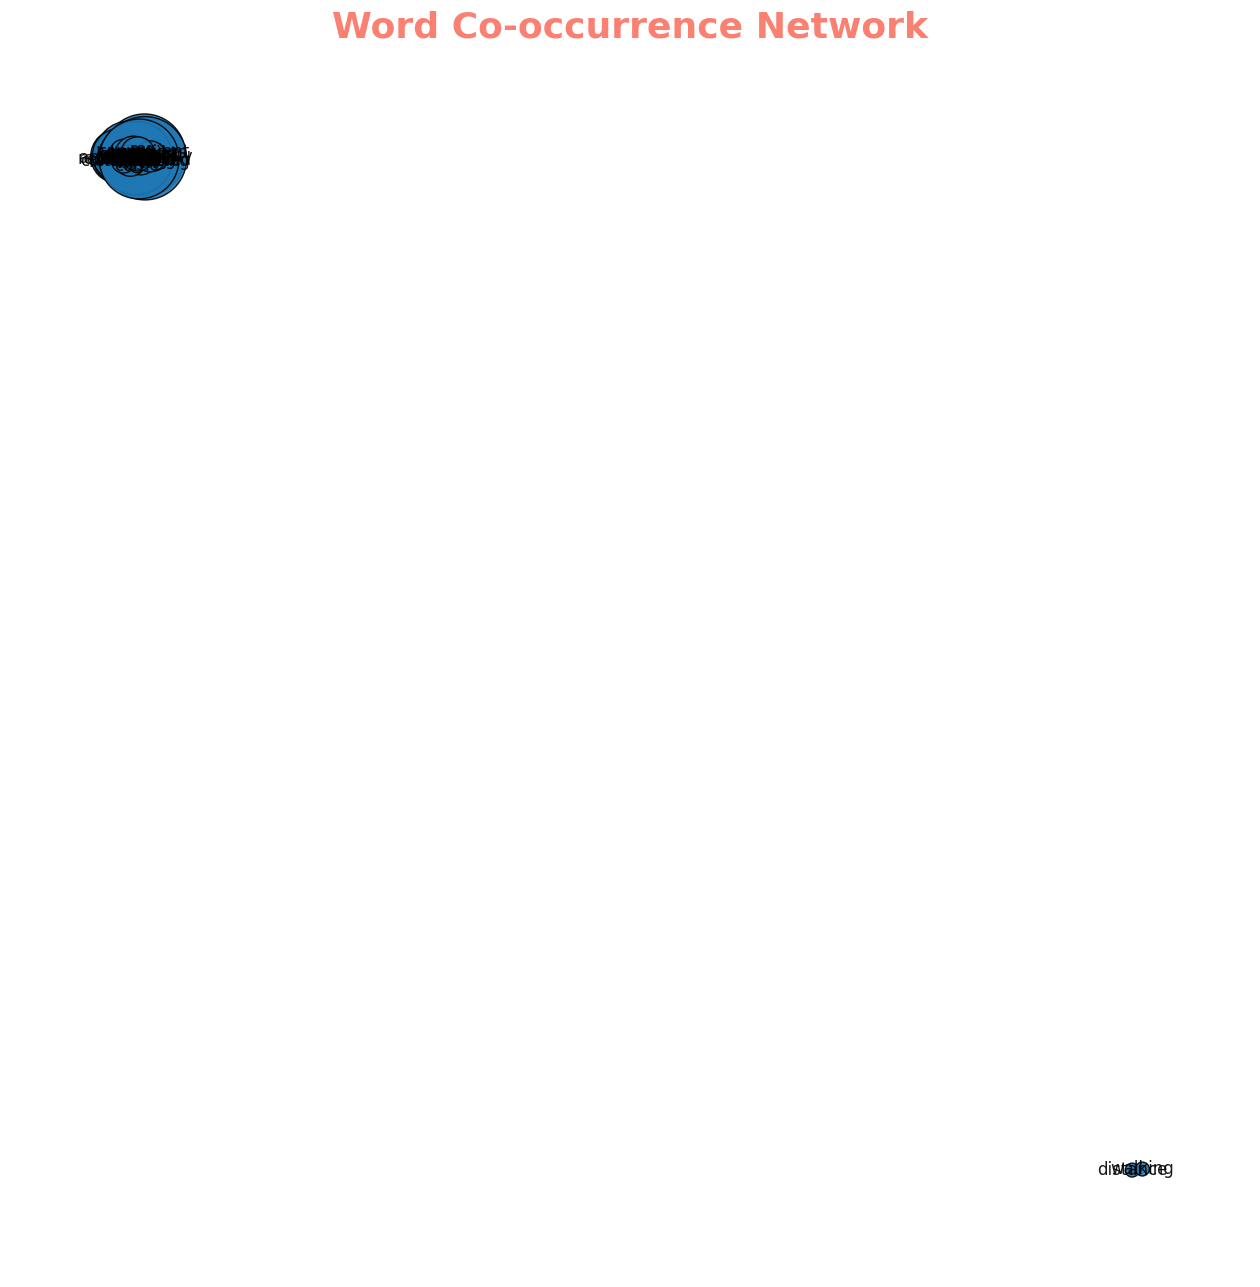

In [28]:
pos_kkl = nx.kamada_kawai_layout(G)
f, ax = plt.subplots(figsize=(16, 16))

d = dict(nx.degree(G))
edges = G.edges()
weights = [G[u][v]['weight']/1000 for u,v in edges]

nx.draw(G, pos_kkl, 
        with_labels=True, 
        node_size=[v * 100 for v in d.values()],
        nodelist=d.keys(),  
        width=weights, 
        edge_color='grey', #node_color=list(df_skills_stats['core_number']), cmap="coolwarm_r", 
        alpha=0.9,
       )
#node_labels = nx.draw_networkx_labels(G, pos_kkl, labels, font_size=10)
# Set title
ax.set_title('Word Co-occurrence Network', 
             fontdict={'fontsize': 26,
            'fontweight': 'bold',
            'color': 'salmon', 
            'verticalalignment': 'baseline',
            'horizontalalignment': 'center'}, 
             loc='center')
# Set edge color
plt.gca().collections[0].set_edgecolor("#000000")

In [15]:
# Create network plot 
G = nx.Graph()

# Create connections between nodes
for v in bigram_counts.most_common(30):
    G.add_edge(v[0][0], v[0][1], weight=(v[1] * 10))

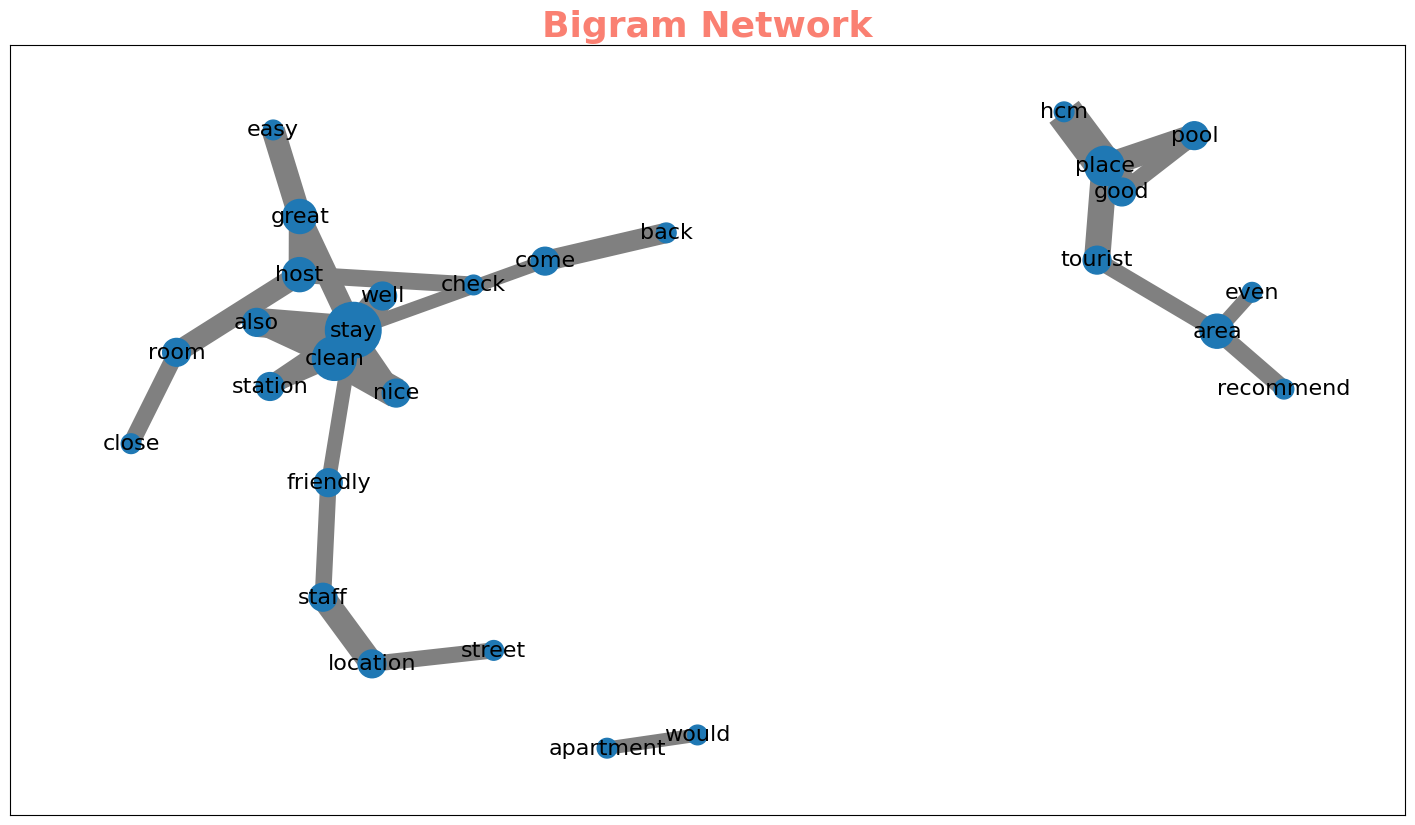

In [16]:
fig, ax = plt.subplots(figsize=(18, 10))

pos = nx.spring_layout(G, k=8)

d = dict(nx.degree(G))
edges = G.edges()
weights = [G[u][v]['weight']/1000 for u,v in edges]
# Plot networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=weights,
                 node_size = [v * 200 for v in d.values()], 
                 edge_color='grey',
                 #node_color='tomato',
                 with_labels = True,
                 ax=ax)

ax.set_title('Bigram Network', 
             fontdict={'fontsize': 26,
            'fontweight': 'bold',
            'color': 'salmon', 
            'verticalalignment': 'baseline',
            'horizontalalignment': 'center'}, 
             loc='center')    
plt.show()